In [40]:
from skimage.feature import hog
from skimage.io import imread
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

import os
import glob
from tqdm import tqdm

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
# plt.rcParams['image.cmap'] = 'gray'


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
def load_negative_samples():
    current_path = os.getcwd()
    pos_train_path_1 = os.path.join(current_path, 'Datasets', 'Tray', 'Ara2013-RPi')
    pos_train_path_2 = os.path.join(current_path, 'Datasets', 'Tray', 'Ara2013-Canon')
    pos_train_path_3 = os.path.join(current_path, 'Datasets', 'Tray', 'Ara2012')

    file_path = []
    for train_path in [pos_train_path_1, pos_train_path_2, pos_train_path_3]:
        for im_path in glob.glob(os.path.join(train_path, '*rgb.png')):
            bbox_path = im_path[:-7]+'bbox.csv'
            file_path.append((im_path, bbox_path))
    
    negative_samples = []
    for file_path_pair in tqdm(file_path):
        samples_from_img = generate_negative_samples(file_path_pair)
        for sample in samples_from_img:
            negative_samples.append(sample)
            
    return negative_samples

In [42]:
def generate_negative_samples(file_path_pair):
    im_path, csv_file_path = file_path_pair
    bboxes = np.loadtxt(csv_file_path, delimiter=',')

    im = imread(im_path)
    positive_patch = list()
    for row in bboxes:
        # Create a Rectangle patch
        width = row[4] - row[0]
        height = row[3] - row[1]
        positive_patch.append([row[0], row[1], width, height])
        
    negative_samples = []
    min_window_size = (100, 100)
    step_size = (100, 100)
    for (x, y, im_window) in sliding_window(im, min_window_size, step_size):
        neg_candidate = (x, y, min_window_size[0], min_window_size[1])
        is_candidate = True
        for pos_candidate in positive_patch:
            if overlapping_area(neg_candidate, pos_candidate) > 0.2:
                is_candidate = False
        if is_candidate:
            negative_samples.append(im_window)
            
    return negative_samples
    

In [43]:
negative_samples = load_negative_samples()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:17<00:00,  3.23it/s]


In [2]:
current_path = os.getcwd()
pos_train_path_1 = os.path.join(current_path, 'Datasets', 'Tray', 'Ara2013-RPi')
pos_train_path_2 = os.path.join(current_path, 'Datasets', 'Tray', 'Ara2013-Canon')
pos_train_path_3 = os.path.join(current_path, 'Datasets', 'Tray', 'Ara2012')

file_path = []
for train_path in [pos_train_path_1, pos_train_path_2, pos_train_path_3]:
    for im_path in glob.glob(os.path.join(train_path, '*rgb.png')):
        bbox_path = im_path[:-7]+'bbox.csv'
        file_path.append((im_path, bbox_path))    
     

(1158, 1647, 3)


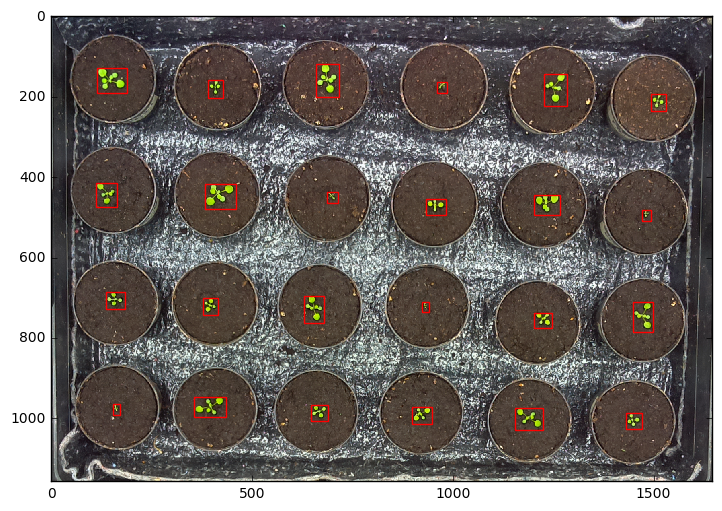

In [9]:
csv_file_path = file_path[0][1]
im_path = file_path[0][0]
bboxes = np.loadtxt(csv_file_path, delimiter=',')

im = imread(im_path)
print(im.shape)
# Create figure and axes
fig, ax = plt.subplots(1)

# Display the image
ax.imshow(im)

positive_patch = list()
for row in bboxes:
    # Create a Rectangle patch
    width = row[4] - row[0]
    height = row[3] - row[1]
    positive_patch.append([row[0], row[1], width, height])
    rect = patches.Rectangle((row[0], row[1]), width, height,linewidth=1,edgecolor='r',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
    
plt.show()

In [31]:
negative_samples = []
min_window_size = (100, 100)
step_size = (100, 100)
for (x, y, im_window) in sliding_window(im, min_window_size, step_size):
    neg_candidate = (x, y, min_window_size[0], min_window_size[1])
    is_candidate = True
    for pos_candidate in positive_patch:
        if overlapping_area(neg_candidate, pos_candidate) > 0.2:
            is_candidate = False
    if is_candidate:
        negative_samples.append(im_window)

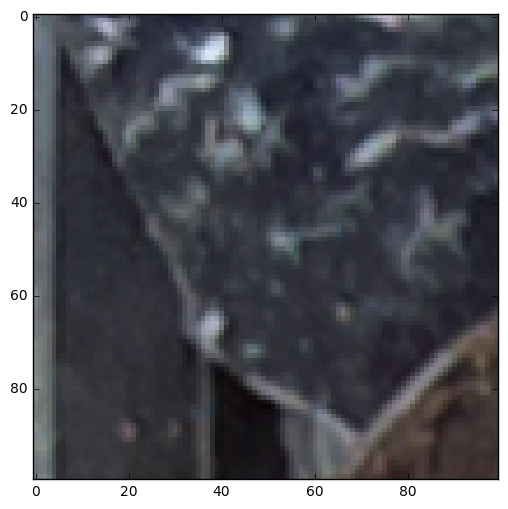

In [33]:
plt.imshow(negative_samples[0])

In [14]:
def overlapping_area(detection_1, detection_2):
    '''
    Function to calculate overlapping area'si
    `detection_1` and `detection_2` are 2 detections whose area
    of overlap needs to be found out.
    Each detection is list in the format ->
    [x-top-left, y-top-left, width-of-detection, height-of-detection]
    The function returns a value between 0 and 1,
    which represents the area of overlap.
    0 is no overlap and 1 is complete overlap.
    Area calculated from ->
    http://math.stackexchange.com/questions/99565/simplest-way-to-calculate-the-intersect-area-of-two-rectangles
    '''
    # Calculate the x-y co-ordinates of the 
    # rectangles
    x1_tl = detection_1[0]
    x2_tl = detection_2[0]
    x1_br = detection_1[0] + detection_1[2]
    x2_br = detection_2[0] + detection_2[2]
    y1_tl = detection_1[1]
    y2_tl = detection_2[1]
    y1_br = detection_1[1] + detection_1[3]
    y2_br = detection_2[1] + detection_2[3]
    # Calculate the overlapping Area
    x_overlap = max(0, min(x1_br, x2_br)-max(x1_tl, x2_tl))
    y_overlap = max(0, min(y1_br, y2_br)-max(y1_tl, y2_tl))
    overlap_area = x_overlap * y_overlap
    area_1 = detection_1[2] * detection_2[3]
    area_2 = detection_2[2] * detection_2[3]
    total_area = area_1 + area_2 - overlap_area
    return overlap_area / float(total_area)

In [11]:
def sliding_window(image, window_size, step_size):
    '''
    This function returns a patch of the input image `image` of size equal
    to `window_size`. The first image returned top-left co-ordinates (0, 0) 
    and are increment in both x and y directions by the `step_size` supplied.
    So, the input parameters are -
    * `image` - Input Image
    * `window_size` - Size of Sliding Window
    * `step_size` - Incremented Size of Window
    The function returns a tuple -
    (x, y, im_window)
    where
    * x is the top-left x co-ordinate
    * y is the top-left y co-ordinate
    * im_window is the sliding window image
    '''
    for y in range(0, image.shape[0], step_size[1]):
        for x in range(0, image.shape[1], step_size[0]):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])